In [5]:
#!nvcc --version

In [6]:
#!pip install testresources

In [8]:
#!pip install -U pip setuptools wheel
#!pip install -U 'spacy[cuda101,transformers,lookups]'

In [10]:
#!pip3 install --upgrade requests

In [12]:
#!pip install sentencepiece

In [1]:
# from datasets import get_dataset_config_names
# from datasets import load_dataset
import spacy
from spacy import displacy
import pandas as pd
import re
import random
import time
import numpy as np
import sys
from itertools import chain
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from spacy.scorer import Scorer

2022-08-09 14:22:49.742552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#spacy.require_gpu()

In [2]:
def load_data_spacy(file_path,flg):
    ''' Converts data from:
    word \t label \n word \t label \n \n word \t label
    to: sentence, {entities : [(start, end, label), (stard, end, label)]}
    '''
    file = open(file_path, 'r')
    training_data, entities, sentence, unique_labels = [], [], [], []
    current_annotation = None
    start =0
    end = 0 # initialize counter to keep track of start and end characters
    for line in file:
        line = line.strip("\n").split(" ")
        if len(line) > 1:
            label = line[len(line)-1]
            #word = "".join(c for c in line[0] if c not in ('!','.',':'))
            word = line[0]
            sentence.append(word)
            start = end
            end += (len(word) + 1)
            if (flg=='X'):
                if(label != 'O'):
                    entities.append(( start,end-1, label)) 
            else:
                entities.append(( start,end-1, label)) 
        if len(line) == 1:
            if(len(entities) > 0):
                sentence = " ".join(sentence)
                training_data.append([sentence, {'entities' : entities}])
            # reset the counters and temporary lists
            end = 0 
            start = 0
            entities, sentence = [], []
            
    file.close()
    return training_data, unique_labels   

In [3]:
DATA, LABELS = load_data_spacy("wikiann-ta.tsv",'X')
TRAIN_DATA = DATA[0:22643]
VALID_DATA = DATA[22644:24153]
TEST_DATA = DATA[24153:25663]

In [4]:
def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    # For spaCy 2.1.4+: this function is available as spacy.util.filter_spans()
    get_sort_key = lambda span: (span.end - span.start, -span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        # Check for end - 1 here because boundaries are inclusive
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
        seen_tokens.update(range(span.start, span.end))
    result = sorted(result, key=lambda span: span.start)
    return result

In [5]:
import pandas as pd
from tqdm import tqdm
import spacy
from spacy.tokens import DocBin
nlp = spacy.blank("en") # load a new spacy model
db = DocBin() # create a DocBin object

for text, annot in tqdm(TRAIN_DATA): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents # label the text with the ents
    db.add(doc)

db.to_disk("./train.spacy") # save the docbin object

db = DocBin()
for text, annot in tqdm(VALID_DATA): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("./valid.spacy") # save the docbin object

100%|██████████| 1509/1509 [00:00<00:00, 2773.89it/s]


In [ ]:
!python -m spacy init fill-config base_config.cfg config.cfg

In [ ]:
!python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./valid.spacy --gpu-id 0 --code functions.py

ℹ Saving to output directory: .
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-06-02 15:26:26,332] [INFO] Set up nlp object from config
[2022-06-02 15:26:26,341] [INFO] Pipeline: ['transformer', 'ner']
[2022-06-02 15:26:26,344] [INFO] Created vocabulary
[2022-06-02 15:26:26,356] [INFO] Finished initializing nlp object
Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fro

In [6]:
nlp_ner = spacy.load("Muril-Large")

In [ ]:
scorer = Scorer()
from spacy.training import Example

examples_valid = []
for text, annots in VALID_DATA:
    predicted=nlp_ner(text)
    example=Example.from_dict(predicted, annots)
    examples_valid.append(example)

examples_test = []
for text, annots in TEST_DATA:
    predicted=nlp_ner(text)
    example=Example.from_dict(predicted, annots)
    examples_test.append(example)

scorer = Scorer()

In [ ]:
scorer.score(examples_valid)

In [ ]:
scorer.score(examples_test)

In [ ]:
DATA, LABELS = load_data_spacy("wikiann-ta.tsv",'Y')
TRAIN_DATA = DATA[0:22643]
VALID_DATA = DATA[22644:24153]
TEST_DATA = DATA[24153:25663]

In [49]:
def get_cleaned_label(label: str):
#     if "-" in label:
#         return label.split("-")[1]
#     else:
#         return label  
    return label 
    
def create_target_vector(doc):
    return [get_cleaned_label(label[2]) for label in doc[1]["entities"]]

def create_total_target_vector(docs):
    target_vector = []
    for doc in docs:
        target_vector.extend(create_target_vector(doc))
    return target_vector

In [50]:
from spacy.training import offsets_to_biluo_tags

def create_prediction_vector(text):
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]
   
def create_total_prediction_vector(docs: list):
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector

def get_all_ner_predictions(text):
    doc = nlp_ner(text)
    n =len(text.split(" "))
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    bilou_entities = [s.replace("U-", "") for s in bilou_entities]
    bilou_entities = [s.replace("L-", "") for s in bilou_entities]
    bilou_entities = [s.replace("B-I", "I") for s in bilou_entities]
    bilou_entities = [s.replace("B-B", "B") for s in bilou_entities]
    bilou_entities = [s.replace("I-I", "I") for s in bilou_entities]
    bilou_entities = [s.replace("I-B", "B") for s in bilou_entities] 
    print(bilou_entities)
    return bilou_entities[0:n] 

In [51]:
def get_model_labels():
    labels = list(nlp.get_pipe("ner").labels)
    labels.append("O")
    return sorted(labels)

In [52]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(docs): 
    classes = sorted(set(create_total_target_vector(docs)))
    y_true = create_total_target_vector(docs)   
    y_pred = create_total_prediction_vector(docs)
    #y_pred = y_pred[0:len(y_true)]
    #print(y_true)
    #print(y_pred)
    return confusion_matrix(y_true, y_pred, classes)

In [53]:
from matplotlib import pyplot
import numpy

def plot_confusion_matrix(docs, classes, normalize=False, cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    title = ' '

    # Compute confusion matrix
    cm = generate_confusion_matrix(docs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm, ax, pyplot

In [54]:
def get_dataset_labels(doc):
    return sorted(set(create_total_target_vector(doc)))

['O', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC']
['O', 'O', 'B-PER', 'I-PER', 'O', 'O']
['O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O']
['B-PER', 'I-PER', 'O', 'B-PER', 'I-PER']
['B-PER', 'I-PER', 'O', 'O', 'O']
['B-PER', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O']
['O', 'B-ORG', 'I-ORG', 'I-ORG']
['O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O']
['O', 'B-LOC', 'I-LOC', 'O', 'O']
['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'B-LOC', 'O', 'O']
['B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER']
['O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O']
['O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG']
['O', 'B-ORG', 'I-ORG', 'I-ORG']
['O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER']
['O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O']
['B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER']
['O', 'B-LOC', 'I-LOC', 'B-LOC', 'I-LOC', 'O', 'O']
['O', 'B

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(array([[ 582,  128,    1,    9,    0,    0,   39],
        [  24,  582,    4,    1,    4,    0,   28],
        [   1,    6,  364,    1,    1,    4,   24],
        [  21,    0,    0,  471,  311,    0,   28],
        [   2,   11,    0,   48, 1219,    6,   33],
        [   0,    1,   72,    0,   12,  442,    9],
        [  17,   18,   21,   11,   16,  107, 6168]]),
 <AxesSubplot:title={'center':' '}, xlabel='Predicted label', ylabel='True label'>,
 <module 'matplotlib.pyplot' from '/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/matplotlib/pyplot.py'>)

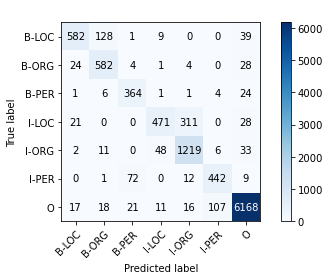

In [55]:
plot_confusion_matrix(VALID_DATA,classes=get_dataset_labels(VALID_DATA),normalize=False)

/home/ubuntu/.local/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


['O', 'O', 'B-LOC', 'O', 'O']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER']
['B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-LOC', 'I-LOC', 'O', 'O']
['O', 'B-PER', 'O', 'O', 'O', 'O']
['O', 'B-LOC', 'I-LOC', 'O', 'O']
['O', 'B-LOC', 'I-LOC', 'O', 'O']
['O', 'B-LOC', 'I-LOC', 'O', 'O', 'O']
['O', 'O', 'B-PER', 'I-PER', 'O', 'O']
['O', 'O', 'B-LOC', 'O', 'O']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER']
['O', 'B-LOC', 'I-LOC', 'O', 'O']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O']
['B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-LOC', 'O', 'B

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(array([[ 535,   53,    4,    1,    3,    0,   63],
        [  37,  585,   11,    1,    5,    1,   31],
        [   1,   11,  439,    0,    0,   15,   34],
        [  20,    0,    0,  433,  134,    2,   20],
        [   4,   28,    1,   53, 1445,   10,   51],
        [   1,    1,   89,    1,   13,  474,   24],
        [  40,   14,   24,   25,   34,   86, 5838]]),
 <AxesSubplot:title={'center':' '}, xlabel='Predicted label', ylabel='True label'>,
 <module 'matplotlib.pyplot' from '/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/matplotlib/pyplot.py'>)

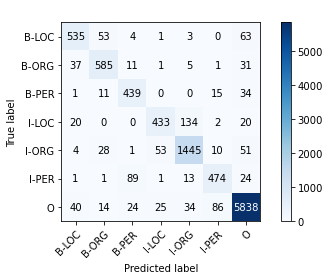

In [56]:
plot_confusion_matrix(TEST_DATA,classes=get_dataset_labels(TEST_DATA),normalize=False)

In [7]:
test_sentences = [x[0] for x in TEST_DATA[0:4000]] # extract the sentences from [sentence, entity]
for x in test_sentences:
    doc = nlp_ner(x)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    displacy.render(doc,jupyter=True, style = "ent")

மும்பையில் 15 25 B-LOC


ஆர்தர் 10 16 B-PER
ஆ. 17 19 I-PER
வில்சன் 20 27 I-PER


இராவணன் 0 7 B-PER


வடக்கு 4 10 B-LOC
கோவாவில் 11 19 I-LOC


பவுலுக்கு 4 13 B-ORG
இத்தேவாலயம் 14 25 I-ORG


திருவரங்கம் 4 15 B-LOC
வட்டத்தில் 16 26 I-LOC


வடக்கு 4 10 B-LOC
கோவாவில் 11 19 I-LOC


கலங்குட் 4 12 B-LOC
கடற்கரையை 13 22 I-LOC


அமல் 27 31 B-PER
நீரத் 32 37 I-PER


கோலாலம்பூர் 5 16 B-LOC


வில்லியம் 10 19 B-PER
டி. 20 23 I-PER
கூலிட்ச் 24 32 I-PER


வடக்கு 4 10 B-LOC
கோவாவில் 11 19 I-LOC


பாகா 90 94 B-LOC
கடற்கரைக்கு 95 106 I-LOC


உருசியாவின் 0 11 B-PER
முதலாம் 12 19 I-PER
பீட்டர் 20 27 I-PER


பொதுநலவாயத்தில் 0 15 B-ORG


குராட்னவ் 20 29 B-LOC
பெலருசுவில் 52 63 B-LOC


ஐதர் 10 14 B-PER
அலி 15 18 I-PER
திப்பு 21 27 B-PER
சுல்தான் 28 36 I-PER


ஐதர் 10 14 B-PER
அலி 15 18 I-PER
திப்பு 21 27 B-PER
சுல்தான் 28 36 I-PER


சலேசிய 0 6 B-ORG
சபைத் 7 12 I-ORG


பாலக்கோடு 4 13 B-LOC
இராயக்கோட்டை 16 28 B-LOC
பிக்கன 75 81 B-LOC
அள்ளி 82 87 I-LOC


ஐதர் 10 14 B-PER
அலி 15 18 I-PER
திப்பு 21 27 B-PER
சுல்தான் 28 36 I-PER


வேதியியல் 5 14 B-LOC


பெர்லிஸ் 0 8 B-LOC


மூவார் 10 16 B-LOC
தங்காக் 19 26 B-LOC


கெந்திங் 10 18 B-LOC
மலை 19 22 I-LOC
கேமரன் 32 38 B-LOC
மலை 39 42 I-LOC


தென்பெண்ணை 0 10 B-LOC
ஆற்றின் 11 18 I-LOC


பாலக்கோடு 9 18 B-LOC
போளு 77 81 B-LOC
அள்ளி 82 87 I-LOC


வட 10 12 B-ORG
மாகாண 13 18 I-ORG
சபை 19 22 I-ORG


மெ. 10 13 B-PER
சரவணன் 14 20 I-PER
( 21 22 I-PER
திரைப்படத் 23 33 I-PER
தயாரிப்பாளர் 34 46 I-PER
) 47 48 I-PER


பாவேந்தரால் 8 19 B-PER


ஜனநாயக 5 11 B-ORG
செயல் 12 17 I-ORG
கட்சி 18 23 I-ORG


ஜனநாயக 5 11 B-ORG
செயல் 12 17 I-ORG
கட்சி 18 23 I-ORG


ஆர். 0 4 B-PER
சுந்தர்ராஜன் 5 17 I-PER
( 18 19 I-PER
இயக்குனர் 20 29 I-PER
) 30 31 I-PER


சிங்பூம் 4 12 B-ORG
மக்களவைத் 13 22 I-ORG
தொகுதிக்கு 23 33 I-ORG


மேற்கு 0 6 B-LOC
சிங்பூம் 7 15 I-LOC
மாவட்டம் 16 24 I-LOC


சமணர் 46 51 B-ORG
மலை 52 55 I-ORG


KeyboardInterrupt: 

In [3]:
file1 = open('NER_Annotated_2.txt', 'r')
Lines = file1.readlines()

In [4]:
for line in Lines:
    #print(line)
    doc = nlp_ner(line)
    #for ent in doc.ents:
        #print(ent)
        #print(ent.text, ent.start_char, ent.end_char, ent.label_)
    displacy.render(doc,jupyter=True, style = "ent")

/home/ubuntu/.local/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


/home/ubuntu/.local/lib/python3.8/site-packages/spacy/displacy/__init__.py:205: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)
